In [25]:
import json
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')
import glob
import matplotlib.pyplot as plt

## Steps to skip as we have a CSV

In [5]:

# load main results
results_df = pd.read_csv("../ALL_DSI-lziv_output.csv", header=0, sep=",")
# load results from human data previous study;
dsi_paper = pd.read_csv('../DSI_output.csv')
lziv_dsi_paper = pd.read_csv('../dsi-paper_DSI-lziv_output.csv')
# change condition name
lziv_dsi_paper['condition'].replace('synopsis', 'flash-fiction', inplace=True)
# load in the human ratings
lziv_dsi_paper[['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'StoryRaterMean']] = dsi_paper[['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'StoryRaterMean']]

# load in gpt4 ratings on the human stories
with open("/home/franc/git/DAT_GPT/samples/sample_gpt4_rater3_temp1.0_story_rater10.json", "r") as f:
    ratings = json.load(f)
ratings = {k: int(v) for k, v in ratings.items()}
# split the gpt4 rating1 column into multiple columns of 179 rows
# not elegant but does the trick
gpt4_ratings = list(ratings.values())
rating1 = gpt4_ratings[0:179]
rating2 = gpt4_ratings[179:358]
rating3 = gpt4_ratings[358:537]
# arrange data
gpt4_ratings = pd.DataFrame()
gpt4_ratings['gpt4_rating1'] = rating1
gpt4_ratings['gpt4_rating2'] = rating2
gpt4_ratings['gpt4_rating3'] = rating3
# compute mean
gpt4_ratings['gpt4_avg'] = gpt4_ratings[['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', ]].mean(axis=1)
# add to human stories dataframe
lziv_dsi_paper[['gpt4_rating1','gpt4_rating2','gpt4_rating3','gpt4_avg']] = gpt4_ratings[['gpt4_rating1','gpt4_rating2','gpt4_rating3', 'gpt4_avg']]
# concatenate the our dataframe with the human data
results_df = pd.concat([results_df ,lziv_dsi_paper], ignore_index=True)

# typo
results_df['temp'].replace('n.a.', 'Mid', inplace=True)

In [19]:
# load in the gpt4 ratings from the machine stories
dict_ratings = {}
for fn in glob.glob("../machine_data_stories/ratings/*.json"):
    with open(fn, "r") as f:
        ratings_ = json.load(f)
    if "rater_GPT4-Mid-flash-fiction" in fn:
        dict_ratings.update({"gpt4":ratings_})
    elif "rater_GPT3-Mid-flash-fiction" in fn:
        dict_ratings.update({"gpt3":ratings_})
    elif "rater_Vicuna-Mid-flash-fiction" in fn:
        dict_ratings.update({"vicuna":ratings_})
    else:
        continue
    

In [20]:
# arrange the ratings in a the main dataframe ; ratings only considered the flash fiction condition
for model in results_df['model'].unique():
    if model == 'human':
        continue
    for idx in dict_ratings[model.lower()].keys():
        # Select the rows that match the condition
        mask = (results_df['model'] == model) & (results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid')
        rows = results_df.loc[mask].copy()
        i = int(idx)+1
        # Set the value for all rows
        rows[f'gpt4_rating{i}'] = [float(val) for val in dict_ratings[model.lower()][idx].values()]

        # Update the original DataFrame with the modified rows
        results_df.loc[mask, rows.columns] = rows

In [21]:
results_df['gpt4_avg'] = results_df[['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']].mean(axis=1)

# Run from here

In [23]:
#results_df.to_csv('../all_stories_dsi_lziv_ratings_num-words.csv', index=False)
results_df = pd.read_csv('../all_stories_dsi_lziv_ratings_num-words.csv')

# Human stories only
## Correlation between gpt4 and human ratings

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.73, p=0.0000')

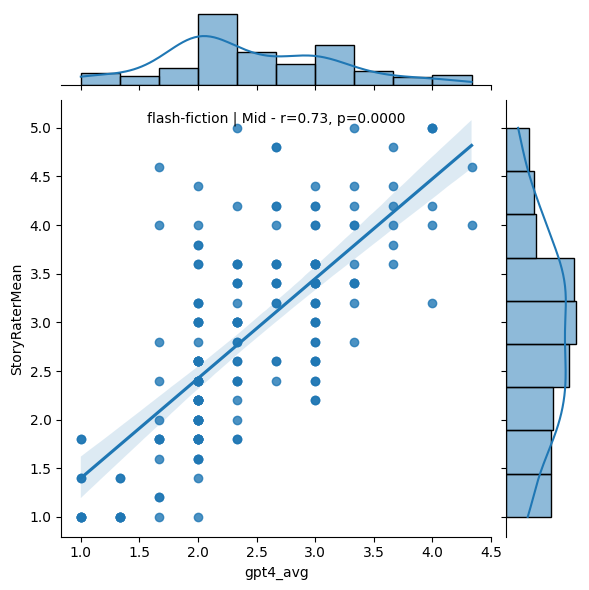

In [20]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']=='human')]
g = sns.jointplot(x='gpt4_avg', y='StoryRaterMean', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['StoryRaterMean'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.75, p=0.0000')

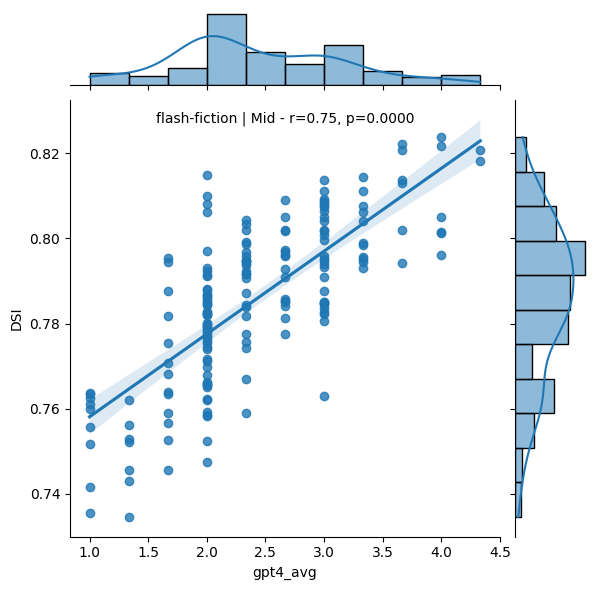

In [24]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']=='human')].dropna(axis=1)
g = sns.jointplot(x='gpt4_avg', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

# LLM stories
## DSI and GPT-4 average rating

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.57, p=0.0000')

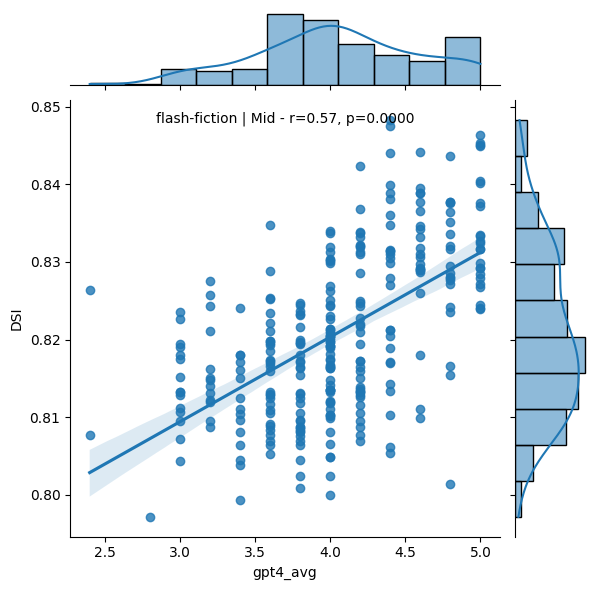

In [21]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']!='human')].dropna(axis=1)
g = sns.jointplot(x='gpt4_avg', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['gpt4_avg'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.4f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')

## Look within model at Mid temp.

GPT4 | flash-fiction | Mid - r=0.14, p=0.16
Vicuna | flash-fiction | Mid - r=0.11, p=0.29
GPT3 | flash-fiction | Mid - r=0.02, p=0.81
human | flash-fiction | Mid - r=0.75, p=0.00


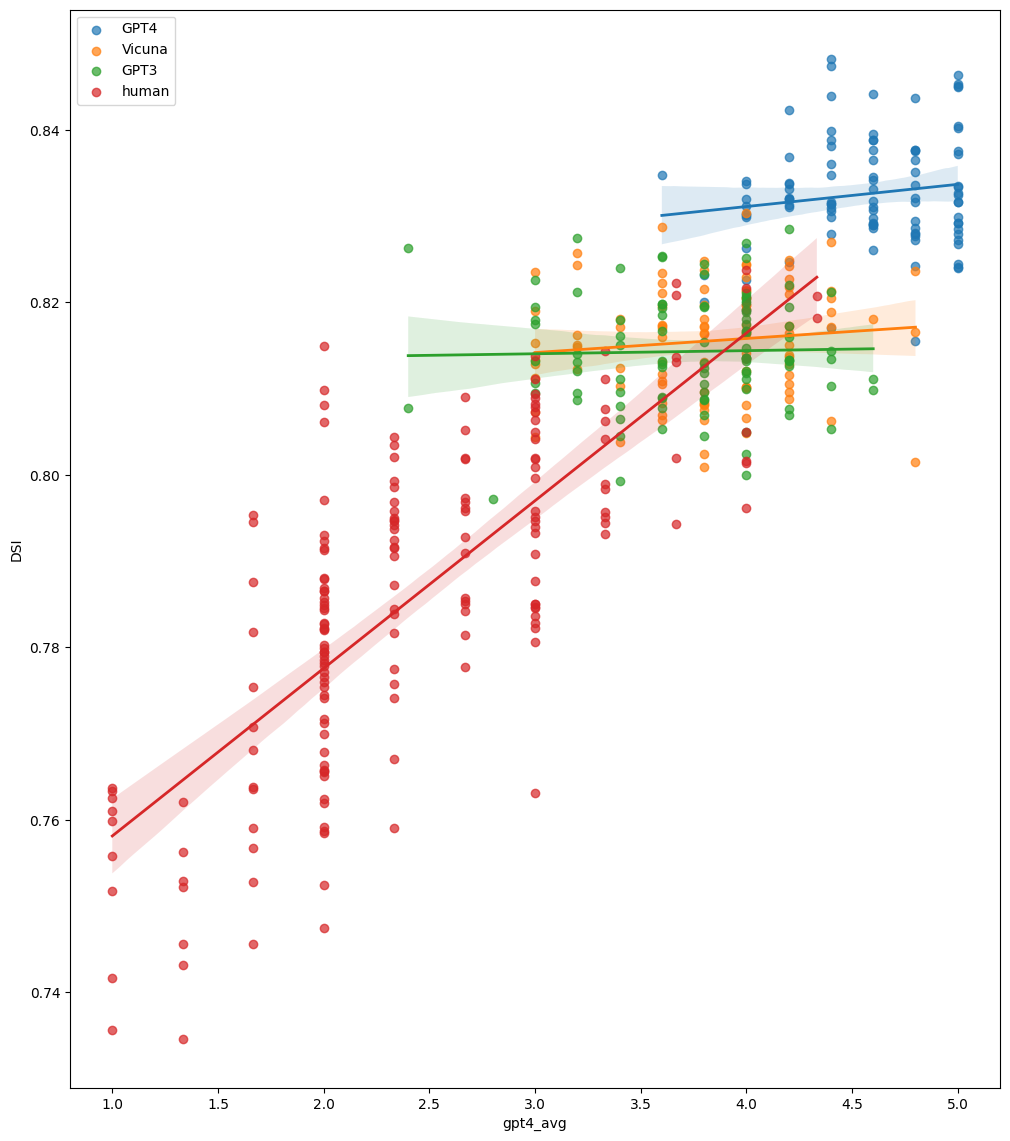

In [22]:
fig, ax= plt.subplots(1, 1, figsize=(12, 14))
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid')].dropna(axis=1)

for model in df['model'].unique():
    sns.regplot(x='gpt4_avg', y='DSI', data=df.loc[df['model']==model], ax=ax, label=model, scatter_kws={'alpha':0.7}, line_kws={'lw':2})
    # add r value and p-value in upper right corner
    df.loc[df['model']==model]['gpt4_avg']
    r, p = stats.pearsonr(df.loc[df['model']==model]['gpt4_avg'], df.loc[df['model']==model]['DSI'])
    print(f"{model} | {condition} | Mid - r={r:.2f}, p={p:.2f}")
plt.legend()
plt.show()
    


# Distribution of ratings ; ranking models

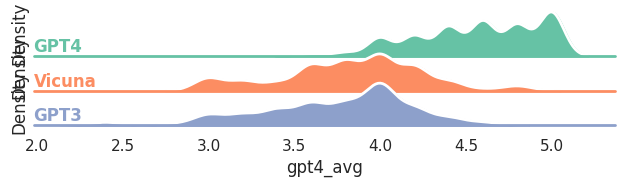

In [26]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition']==condition) &
                    (results_df['temp']=='Mid') &
                    (results_df['model']!='human')]

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette='Set2')

# Draw the densities in a few steps
g.map(sns.kdeplot, "gpt4_avg", clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5,)
g.map(sns.kdeplot, "gpt4_avg", clip_on=False, color="w", lw=2, bw_adjust=.5,)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "gpt4_avg")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

## For each rating instance

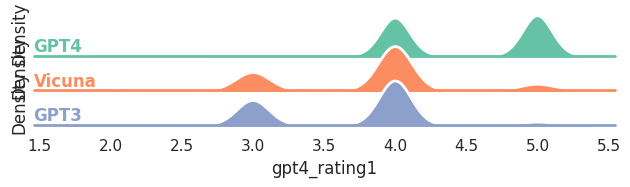

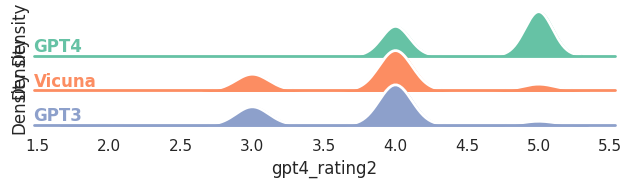

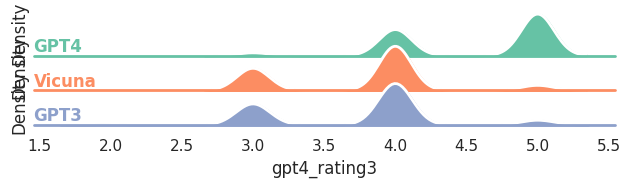

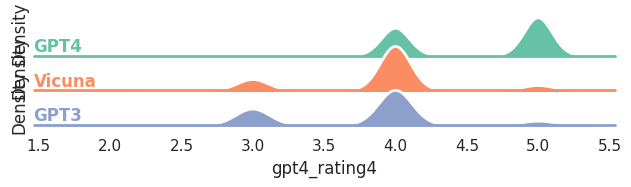

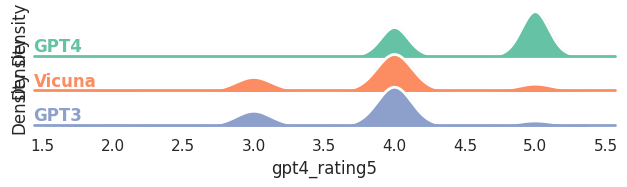

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
condition = 'flash-fiction'
df = results_df.loc[(results_df['condition'] == condition) &
                    (results_df['temp'] == 'Mid') &
                    (results_df['model'] != 'human')]

# Create a "combined" column to merge model and rater information
for rating_column in ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']:
    df[rating_column + '_combined'] = df['model'] + ' - ' + rating_column

# Now, we'll initialize the FacetGrid multiple times, once for each rater, and plot them
for rating_column in ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']:
    
    g = sns.FacetGrid(df, row=rating_column + '_combined', hue="model", aspect=15, height=.5, palette='Set2')

    g.map(sns.kdeplot, rating_column, clip_on=False, fill=True, alpha=1, lw=1.5, bw_adjust=.5)
    g.map(sns.kdeplot, rating_column, clip_on=False, color="w", lw=2, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label.split(' - ')[0], fontweight="bold", color=color,  # Only the model name is displayed
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, rating_column)

    # Set the subplots to overlap and remove axes details
    g.fig.subplots_adjust(hspace=-.25)
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)


# Multiple regression models
## Human stories

In [25]:
import pingouin as pg
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']=='human')]
stats_df = pg.linear_regression(X=df[['num_words', 'lziv', 'gpt4_avg']], y=df['DSI'], relimp=True)
stats_df.round(4)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,0.6862,0.0195,35.1470,0.0000,0.6391,0.6329,0.6477,0.7247,NaN,NaN
1,num_words,0.0002,0.0000,5.9107,0.0000,0.6391,0.6329,0.0001,0.0002,0.2230,34.9012
2,lziv,0.0682,0.0287,2.3735,0.0187,0.6391,0.6329,0.0115,0.1248,0.0222,3.4756
3,gpt4_avg,0.0147,0.0014,10.4099,0.0000,0.6391,0.6329,0.0119,0.0175,0.3938,61.6232


## LLM stories

In [26]:
import pingouin as pg
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']!='human')]
stats_df = pg.linear_regression(X=df[['num_words', 'lziv', 'gpt4_avg']], y=df['DSI'], relimp=True)
stats_df.round(4)


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%],relimp,relimp_perc
0,Intercept,0.6742,0.0155,43.6355,0.0000,0.5012,0.4961,0.6438,0.7046,NaN,NaN
1,num_words,0.0002,0.0000,9.9158,0.0000,0.5012,0.4961,0.0001,0.0002,0.2729,54.4496
2,lziv,0.0885,0.0251,3.5196,0.0005,0.5012,0.4961,0.0390,0.1380,0.0275,5.4779
3,gpt4_avg,0.0061,0.0009,6.7295,0.0000,0.5012,0.4961,0.0043,0.0079,0.2008,40.0725


## Let's look into number of words

Text(0.5, 0.95, 'flash-fiction | Mid - r=0.61, p=0.00')

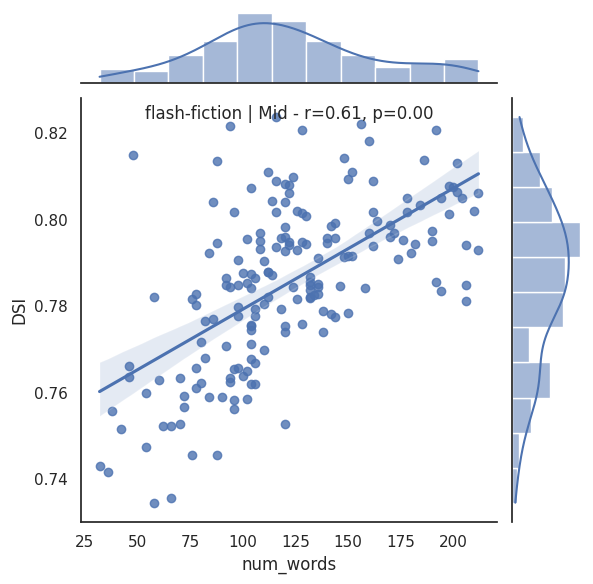

In [27]:
condition = 'flash-fiction'

df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']=='human')]

g = sns.jointplot(x='num_words', y='DSI', data=df ,kind='reg')
# add r value and p-value in upper right corner
r, p = stats.pearsonr(df['num_words'], df['DSI'])
g.ax_joint.annotate(f"{condition} | Mid - r={r:.2f}, p={p:.2f}", xy=(0.5, 0.95), xycoords='axes fraction', ha='center')


In [29]:
import statsmodels.api as sm
df = results_df.loc[(results_df['condition']==condition) &  (results_df['temp']=='Mid') & (results_df['model']!='human')].copy()
# create the X and y arrays for the regression model
X = df[['num_words', 'lziv', 'DSI']]
y = df['gpt4_avg']

# add a constant to the X array
X = sm.add_constant(X)

# fit the regression model
model = sm.OLS(y, X).fit()

# perform the F-test
t_test = model.t_test('DSI = lziv = num_words = 0')
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            18.4499      3.892      4.740      0.000      10.790      26.110
c1             3.1469      1.511      2.083      0.038       0.173       6.120
c2             0.0042      0.001      3.793      0.000       0.002       0.006


# Inter-rater reliability
## Cohen's kappa on human stories

In [29]:
from sklearn.metrics import cohen_kappa_score
filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == 'human')]

# calculate Cohen's kappa for the human raters
human_ratings = ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5']
human_kappas = []
for i in range(len(human_ratings)):
    for j in range(i+1, len(human_ratings)):
        kappa = cohen_kappa_score(filtered_df[human_ratings[i]], filtered_df[human_ratings[j]])
        human_kappas.append(kappa)

# calculate Cohen's kappa for the gpt4 ratings
gpt4_ratings = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3']
gpt4_kappas = []
for i in range(len(gpt4_ratings)):
    for j in range(i+1, len(gpt4_ratings)):
        kappa = cohen_kappa_score(filtered_df[gpt4_ratings[i]], filtered_df[gpt4_ratings[j]])
        gpt4_kappas.append(kappa)

# print the average kappa for each group of raters
print(f"Average Cohen's kappa for human raters: {sum(human_kappas)/len(human_kappas):.2f}")
print(f"Average Cohen's kappa for gpt4 raters: {sum(gpt4_kappas)/len(gpt4_kappas):.2f}")

Average Cohen's kappa for human raters: 0.25
Average Cohen's kappa for gpt4 raters: 0.48


In [33]:
from sklearn.metrics import cohen_kappa_score
for model in results_df['model'].unique():
    if model == 'human':
        continue
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == model)]

    # calculate Cohen's kappa for the gpt4 ratings
    gpt4_ratings = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
    gpt4_kappas = []
    for i in range(len(gpt4_ratings)):
        for j in range(i+1, len(gpt4_ratings)):
            kappa = cohen_kappa_score(filtered_df[gpt4_ratings[i]], filtered_df[gpt4_ratings[j]])
            gpt4_kappas.append(kappa)

    # print the average kappa for raters
    print(f"Average Cohen's kappa for gpt4 raters on {model} stories: {sum(gpt4_kappas)/len(gpt4_kappas):.2f}")

Average Cohen's kappa for gpt4 raters on GPT3 stories: 0.30
Average Cohen's kappa for gpt4 raters on GPT4 stories: 0.31
Average Cohen's kappa for gpt4 raters on Vicuna stories: 0.27


In [34]:
import numpy as np

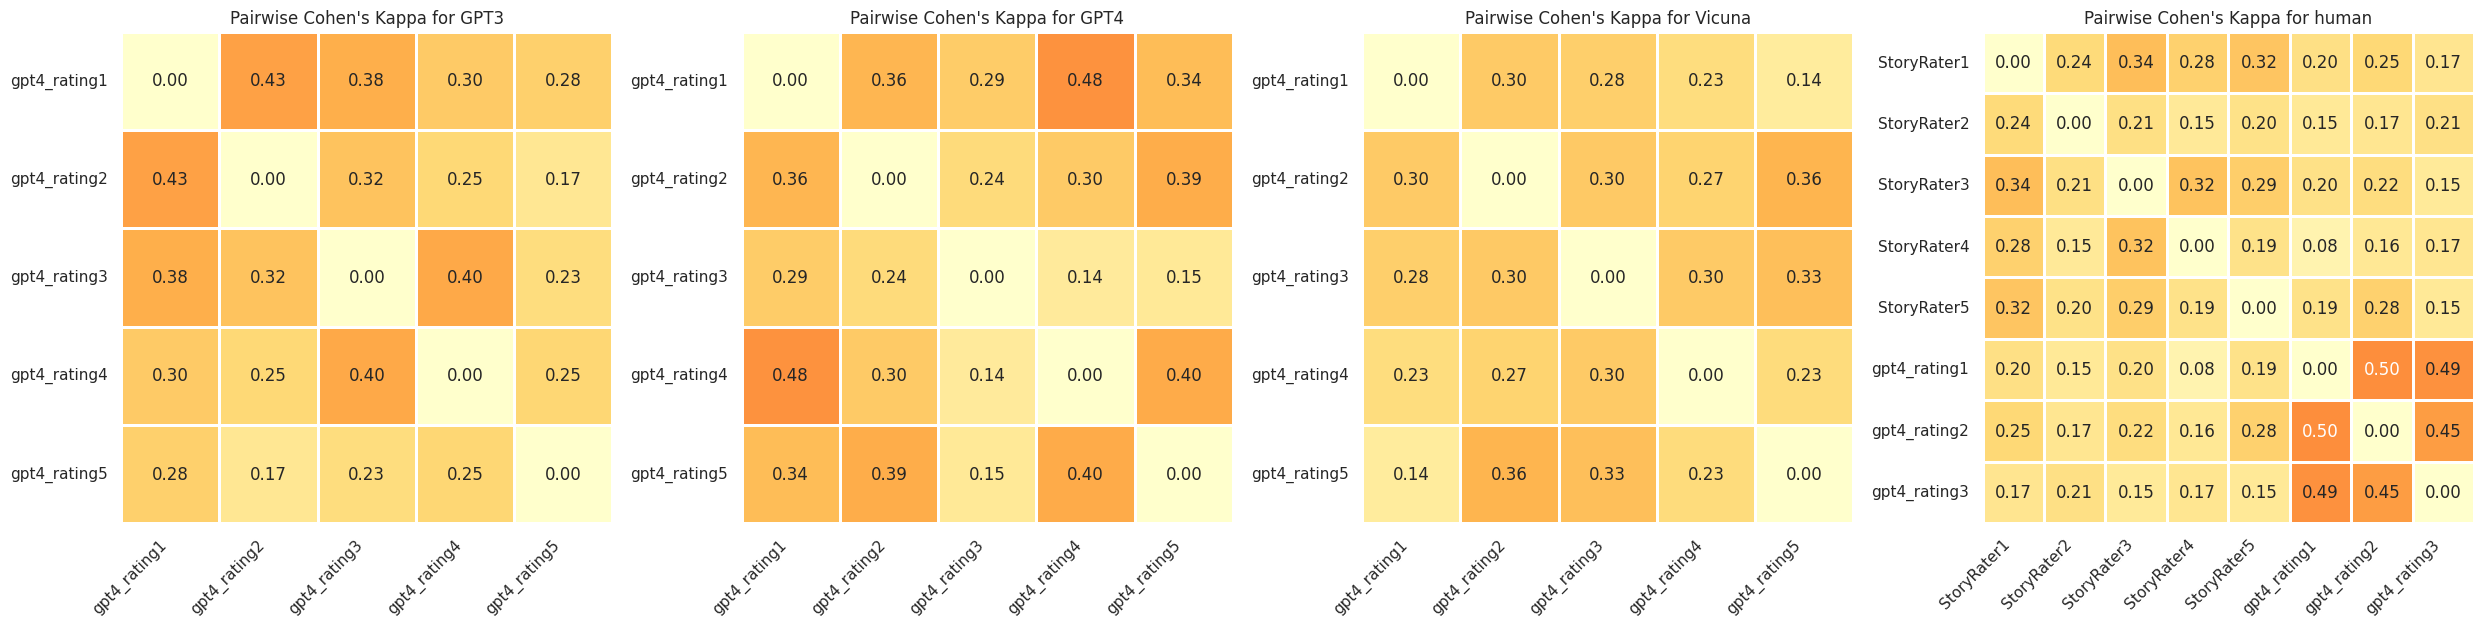

In [35]:
# Update rater mapping for 'human' to include both human and 3 GPT-4 raters
raters = {}
raters['human'] = ['StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4', 'StoryRater5', 'gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3']

# Models to consider
selected_models = ['GPT3', 'GPT4', 'Vicuna', 'human']
raters['GPT3'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
raters['GPT4'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
raters['Vicuna'] = ['gpt4_rating1', 'gpt4_rating2', 'gpt4_rating3', 'gpt4_rating4', 'gpt4_rating5']
# Recompute the kappa matrices for the selected models
selected_model_kappa_results = {}
for model in selected_models:
    model_raters = raters[model]
    filtered_df = results_df[(results_df['condition'] == 'flash-fiction') & (results_df['temp'] == 'Mid') & (results_df['model'] == model)].dropna(axis=1)
    
    # Drop rows with any NaN in model raters
    filtered_df = filtered_df.dropna(subset=model_raters)
    
    # Create a matrix to store kappa scores
    kappa_matrix = np.zeros((len(model_raters), len(model_raters)))
    
    for i in range(len(model_raters)):
        for j in range(len(model_raters)):
            if i != j:
                kappa_matrix[i, j] = cohen_kappa_score(filtered_df[model_raters[i]], filtered_df[model_raters[j]])
                
    selected_model_kappa_results[model] = kappa_matrix

# Plot the matrix plots for the selected models using a warm palette
plt.figure(figsize=(25, 15))

for idx, (model, kappa_matrix) in enumerate(selected_model_kappa_results.items()):
    ax = plt.subplot(1, len(selected_model_kappa_results), idx+1)
    
    # Plot the matrix with annotations using the "YlOrRd" (yellow-orange-red) palette
    sns.heatmap(kappa_matrix, annot=True, cmap="YlOrRd", cbar=False, ax=ax, 
                vmin=0, vmax=1, linewidths=1, square=True, fmt=".2f")
    
    ax.set_xticks(np.arange(len(raters[model]))+0.5)
    ax.set_xticklabels(raters[model], rotation=45, ha='right')
    ax.set_yticks(np.arange(len(raters[model]))+0.5)
    ax.set_yticklabels(raters[model], rotation=0)
    ax.set_title(f"Pairwise Cohen's Kappa for {model}")

plt.tight_layout()
plt.show()